# Análise preditiva do Programa Mais Médicos

## 1. Análise preditiva para desfecho categórico (churn)

In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import optuna




### Carregamento dos dados

In [2]:
df_completo = pd.read_csv(r"C:\Users\alefs\OneDrive\Documentos\GitHub\sa_maismedicos\01_dados\dados resultantes\df_modelagem.csv")

list(df_completo.columns)

['Unnamed: 0',
 'meses_no_local_alocado',
 'churn',
 'idade',
 'anos_formacao',
 'atuacao_previa_no_municipio',
 'anos_atuacao_previa_no_municipio',
 'media_vinculos_mes',
 'Prorrogado',
 'm_agente_saude',
 'm_tec_aux_enf',
 'm_enfermeiro',
 'm_dentista',
 'regiao_destino',
 'populacao',
 'porte',
 'pib_percapita',
 'variacao_pib',
 'tx_pop_ocupada_2019',
 'orcamento_saude',
 'esgotamento_sanitario',
 'taxa_homicidio',
 'ideb_anosfinais',
 'investimento_infraestrutura',
 'equipamentos_esportivos',
 'equipamentos_culturais',
 'distancia_capital']

In [3]:
df_completo = df_completo.drop(["Unnamed: 0",
              "meses_no_local_alocado"], 
             axis='columns')

df_completo[['m_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro', 'm_dentista']] = df_completo[['m_agente_saude', 'm_tec_aux_enf', 
                                                                                     'm_enfermeiro', 'm_dentista']].fillna(0)
df_completo['churn'] = df_completo['churn'].map({'permanece': 0, 'migrou': 1})

df_m1 = df_completo[['churn', 'idade', 'anos_formacao', 'atuacao_previa_no_municipio' ,'anos_atuacao_previa_no_municipio',
                   'regiao_destino']]

df_m2 = df_completo[['churn', 'idade', 'anos_formacao', 'atuacao_previa_no_municipio' ,'anos_atuacao_previa_no_municipio',
                   'media_vinculos_mes', 'm_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro', 'm_dentista']]

df_m3 = df_completo.drop(['Prorrogado'], axis='columns')

df_m4 = df_completo

In [7]:
df_m2.columns

Index(['churn', 'idade', 'anos_formacao', 'atuacao_previa_no_municipio',
       'anos_atuacao_previa_no_municipio', 'media_vinculos_mes',
       'm_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro', 'm_dentista'],
      dtype='object')

### Pré-processamento e divisão em treino e teste

In [9]:
def dividir_e_balancear(df):
    y = df['churn']  
    X = df.drop(columns=['churn']) 

    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])
    
    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Aplicar o pré-processamento
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Aplicação do SMOTE para balanceamento
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    y_train = y_train.astype(int)  # Garantir que y_train seja numérico
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    
    return X_train_resampled, X_test_processed, y_train_resampled, y_test, preprocessor

In [10]:
X_train_m1, X_test_m1, y_train_m1, y_test_m1, preprocessor_m1 = dividir_e_balancear(df_m1)
X_train_m2, X_test_m2, y_train_m2, y_test_m2, preprocessor_m2 = dividir_e_balancear(df_m2)
X_train_m3, X_test_m3, y_train_m3, y_test_m3, preprocessor_m3 = dividir_e_balancear(df_m3)
X_train_m4, X_test_m4, y_train_m4, y_test_m4, preprocessor_m4 = dividir_e_balancear(df_m4)

In [8]:
X_train_m3

array([[ 2.85361594,  4.10411297, -0.2427141 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.90628503, -0.56863868, -0.2427141 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.61799915, -0.47908717, -0.2427141 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.41356014,  3.20154144, -0.2427141 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.22448607,  0.02868806, -0.2427141 , ...,  0.        ,
         1.        ,  0.        ],
       [ 2.31088907,  2.84581786, -0.2427141 , ...,  0.8681608 ,
         0.        ,  0.        ]])

## Instanciando modelos e rodando modelos

No bloco de código abaixo é definida a função para treinar e avaliar os modelos sem Optuna.

In [11]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}

param_grids = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'classifier__max_depth': [3, 5, 10]},
    'Random Forest': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 5, 10],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__subsample': [0.7, 0.85, 1.0],
        'classifier__colsample_bytree': [0.7, 0.85, 1.0],
        'classifier__gamma': [0, 0.1, 0.5]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [20, 31, 40],
        'classifier__min_child_samples': [10, 20, 30]
    }
}


def treinando_avaliando(x_train, y_train, x_test, y_test):
    # Validação cruzada e otimização de hiperparâmetros
    best_models = {}

    for name, model in models.items():
        print(f"Treinando modelo: {name}")
        pipeline = Pipeline([('classifier', model)])

        param_grid = param_grids.get(name, {})
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(x_train, y_train)

        best_models[name] = grid_search.best_estimator_
        print(f"Melhores parâmetros para {name}: {grid_search.best_params_}\n")

    # Avaliação final no conjunto de teste
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob)
        })
    
    return results, models

No bloco de código abaixo é definida a função para treinar e avaliar os modelos com Optuna.

In [12]:
# Definir uma função objetivo para o Optuna
def objective(trial, model_name, x_train, y_train):
    # Definir os hiperparâmetros a serem otimizados para cada modelo
    if model_name == 'Logistic Regression':
        C = trial.suggest_loguniform('C', 0.01, 10)
        model = LogisticRegression(C=C)
    
    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = DecisionTreeClassifier(max_depth=max_depth)
    
    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        subsample = trial.suggest_float('subsample', 0.7, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1.0)
        gamma = trial.suggest_float('gamma', 0, 0.5)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, use_label_encoder=False, eval_metric='logloss')
    
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        num_leaves = trial.suggest_int('num_leaves', 20, 40)
        min_child_samples = trial.suggest_int('min_child_samples', 10, 30)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples)
    
    # Treinamento do modelo
    model.fit(x_train, y_train)
    
    # Obter a probabilidade da classe positiva (para calcular o ROC AUC)
    y_prob = model.predict_proba(x_train)[:, 1]
    
    # Calcular o ROC AUC para esta combinação de hiperparâmetros
    roc_auc = roc_auc_score(y_train, y_prob)
    
    # Retornar tanto o modelo quanto o ROC AUC
    return model, roc_auc

def treinando_avaliando_optuna(x_train, y_train, x_test, y_test):
    best_models = {}
    best_roc_auc = {}

    for name in models.keys():
        print(f"Treinando modelo com Optuna: {name}")

        # Otimização de hiperparâmetros com Optuna
        study = optuna.create_study(direction="maximize")  # Maximizar o ROC AUC
        study.optimize(lambda trial: objective(trial, name, x_train, y_train)[1], n_trials=10)  # Aqui estamos otimizar apenas o ROC AUC

        # Obter o melhor modelo do estudo
        best_model, best_roc = objective(study.best_trial, name, x_train, y_train)
        best_models[name] = best_model
        best_roc_auc[name] = best_roc
        
        print(f"Melhores parâmetros para {name}: {study.best_params}\n")

    # Avaliação final no conjunto de teste
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob)
        })
    
    return results, models

### Modelo 1

In [8]:
results_m1, models_m1 = treinando_avaliando_optuna(X_train_m1, y_train_m1, X_test_m1, y_test_m1)
results_m1_df = pd.DataFrame(results_m1)
print(results_m1_df.sort_values(by='ROC AUC', ascending=False))

[I 2025-02-26 12:46:10,496] A new study created in memory with name: no-name-ac1acd3d-5480-4187-b1fe-ee6b2141604e
C:\Users\alefs\AppData\Local\Temp\ipykernel_23436\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-02-26 12:46:10,516] Trial 0 finished with value: 0.6893853112668081 and parameters: {'C': 0.010021841078385382}. Best is trial 0 with value: 0.6893853112668081.
C:\Users\alefs\AppData\Local\Temp\ipykernel_23436\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-02-26 12:46:10,525] Trial 1 finished with value: 0.6897667497979348 and p

Treinando modelo com Optuna: Logistic Regression
Melhores parâmetros para Logistic Regression: {'C': 0.23850179350821185}

Treinando modelo com Optuna: Decision Tree


[I 2025-02-26 12:46:10,691] A new study created in memory with name: no-name-8e0e942c-b8c8-4866-b562-bb80d7a50375


Melhores parâmetros para Decision Tree: {'max_depth': 10}

Treinando modelo com Optuna: Random Forest


[I 2025-02-26 12:46:11,478] Trial 0 finished with value: 0.9126338276546176 and parameters: {'n_estimators': 400, 'max_depth': 9, 'min_samples_split': 9}. Best is trial 0 with value: 0.9126338276546176.
[I 2025-02-26 12:46:11,910] Trial 1 finished with value: 0.9379222297621466 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 6}. Best is trial 1 with value: 0.9379222297621466.
[I 2025-02-26 12:46:12,920] Trial 2 finished with value: 0.9291410393281496 and parameters: {'n_estimators': 500, 'max_depth': 9, 'min_samples_split': 2}. Best is trial 1 with value: 0.9379222297621466.
[I 2025-02-26 12:46:13,537] Trial 3 finished with value: 0.8083509104818876 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 1 with value: 0.9379222297621466.
[I 2025-02-26 12:46:14,153] Trial 4 finished with value: 0.8063135100557137 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 8}. Best is trial 1 with value: 0.93

Melhores parâmetros para Random Forest: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5}

Treinando modelo com Optuna: XGBoost


C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-26 12:46:17,665] Trial 1 finished with value: 0.9888042928583468 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.09584165463075102, 'subsample': 0.7257895403416232, 'colsample_bytree': 0.8924561787591818, 'gamma': 0.07524507366711275}. Best is trial 1 with value: 0.9888042928583468.
C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-26 12:46:17,730] Trial 2 finish

Melhores parâmetros para XGBoost: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.09584165463075102, 'subsample': 0.7257895403416232, 'colsample_bytree': 0.8924561787591818, 'gamma': 0.07524507366711275}

Treinando modelo com Optuna: LightGBM
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

[I 2025-02-26 12:46:19,120] Trial 1 finished with value: 0.9919287390701111 and parameters: {'n_estimators': 500, 'learning_rate': 0.09291400109743293, 'num_leaves': 24, 'min_child_samples': 17}. Best is trial 1 with value: 0.9919287390701111.
[I 2025-02-26 12:46:19,270] Trial 2 finished with value: 0.9848986000233401 and parameters: {'n_estimators': 300, 'learning_rate': 0.08113847302533936, 'num_leaves': 34, 'min_child_samples': 27}. Best is trial 1 with value: 0.9919287390701111.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-26 12:46:19,420] Trial 3 finished with value: 0.9835570817899301 and parameters: {'n_estimators': 500, 'learning_rate': 0.04601274991323385, 'num_leaves': 21, 'min_child_samples': 10}. Best is trial 1 with value: 0.9919287390701111.
[I 2025-02-26 12:46:19,483] Trial 4 finished with value: 0.9712786511123309 and parameters: {'n_estimators': 100, 'learning_rate': 0.08901375932846664, 'num_leaves': 37, 'min_child_samples': 16}. Best is trial 1 with value: 0.9919287390701111.
[I 2025-02-26 12:46:19,620] Trial 5 finished with value: 0.9619960797195725 and parameters: {'n_estimators': 300, 'learning_rate': 0.042910895957059374, 'num_leaves': 28, 'min_child_samples': 30}. Best is trial 1 with value: 0.9919287390701111.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-26 12:46:19,743] Trial 6 finished with value: 0.9801403434459568 and parameters: {'n_estimators': 200, 'learning_rate': 0.07981881052089085, 'num_leaves': 39, 'min_child_samples': 27}. Best is trial 1 with value: 0.9919287390701111.
[I 2025-02-26 12:46:19,791] Trial 7 finished with value: 0.9282998214910898 and parameters: {'n_estimators': 100, 'learning_rate': 0.06567595235328337, 'num_leaves': 21, 'min_child_samples': 28}. Best is trial 1 with value: 0.9919287390701111.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[Ligh

[I 2025-02-26 12:46:19,904] Trial 8 finished with value: 0.9856852494586382 and parameters: {'n_estimators': 400, 'learning_rate': 0.07040896372507788, 'num_leaves': 21, 'min_child_samples': 12}. Best is trial 1 with value: 0.9919287390701111.
[I 2025-02-26 12:46:20,087] Trial 9 finished with value: 0.9809529263791217 and parameters: {'n_estimators': 400, 'learning_rate': 0.05090066846223049, 'num_leaves': 32, 'min_child_samples': 24}. Best is trial 1 with value: 0.9919287390701111.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'n_estimators': 500, 'learning_rate'

In [13]:
best_model_name = results_m1_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
best_model_m1 = models_m1[best_model_name]

In [57]:
# Treinando o modelo
best_model_m1.fit(X_train_m1, y_train_m1)

# Fazendo previsões no conjunto de teste
y_pred = best_model_m1.predict(X_test_m1)

# Imprimindo o relatório de classificação
print(classification_report(y_test_m1, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.67      0.51        72
           1       0.88      0.72      0.79       241

    accuracy                           0.71       313
   macro avg       0.65      0.69      0.65       313
weighted avg       0.77      0.71      0.73       313



In [11]:
import shap

shap.initjs() #habilitando a visualização dos gráficos

In [11]:
explainer = shap.KernelExplainer(best_model_m1.predict, 
                           X_test_m1)

shap_values = explainer(X_test_m1)

Provided model function fails when applied to the provided data set.


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [12]:
shap.summary_plot(shap_values, features= X_train_m1, 
                  feature_names= df_m1.columns, 
                  plot_type="bar")

NameError: name 'shap_values' is not defined

### Modelo 2

In [14]:
results_m2, models_m2 = treinando_avaliando_optuna(X_train_m2, y_train_m2, X_test_m2, y_test_m2)
results_m2_df = pd.DataFrame(results_m2)
print(results_m2_df.sort_values(by='ROC AUC', ascending=False))

[I 2025-02-26 12:54:10,717] A new study created in memory with name: no-name-e92a1ad5-6437-4a98-839e-cc5295bc81bd
C:\Users\alefs\AppData\Local\Temp\ipykernel_23436\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-02-26 12:54:10,729] Trial 0 finished with value: 0.7198036834211471 and parameters: {'C': 0.12874130291902539}. Best is trial 0 with value: 0.7198036834211471.
C:\Users\alefs\AppData\Local\Temp\ipykernel_23436\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-02-26 12:54:10,737] Trial 1 finished with value: 0.7201029992090282 and pa

Treinando modelo com Optuna: Logistic Regression
Melhores parâmetros para Logistic Regression: {'C': 2.65337770110608}

Treinando modelo com Optuna: Decision Tree


[I 2025-02-26 12:54:10,916] Trial 6 finished with value: 0.9564565765189466 and parameters: {'max_depth': 9}. Best is trial 4 with value: 0.9737428736908986.
[I 2025-02-26 12:54:10,926] Trial 7 finished with value: 0.7901331685115469 and parameters: {'max_depth': 4}. Best is trial 4 with value: 0.9737428736908986.
[I 2025-02-26 12:54:10,937] Trial 8 finished with value: 0.8694880511408578 and parameters: {'max_depth': 6}. Best is trial 4 with value: 0.9737428736908986.
[I 2025-02-26 12:54:10,953] Trial 9 finished with value: 0.9339360350275112 and parameters: {'max_depth': 8}. Best is trial 4 with value: 0.9737428736908986.
[I 2025-02-26 12:54:10,954] A new study created in memory with name: no-name-2cec6c3b-4149-400b-bf39-bd2f90d3d537


Melhores parâmetros para Decision Tree: {'max_depth': 10}

Treinando modelo com Optuna: Random Forest


[I 2025-02-26 12:54:11,537] Trial 0 finished with value: 0.9165287148655131 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 0 with value: 0.9165287148655131.
[I 2025-02-26 12:54:12,220] Trial 1 finished with value: 0.8505841520394535 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 6}. Best is trial 0 with value: 0.9165287148655131.
[I 2025-02-26 12:54:13,254] Trial 2 finished with value: 0.8843355189509037 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 0 with value: 0.9165287148655131.
[I 2025-02-26 12:54:14,237] Trial 3 finished with value: 0.8203510963386224 and parameters: {'n_estimators': 500, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.9165287148655131.
[I 2025-02-26 12:54:14,820] Trial 4 finished with value: 0.8184082451234218 and parameters: {'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 9}. Best is trial 0 with value: 0.916

Melhores parâmetros para Random Forest: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 3}

Treinando modelo com Optuna: XGBoost


C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-26 12:54:18,641] Trial 0 finished with value: 0.9999805498765998 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.027308189329692867, 'subsample': 0.9193782754542364, 'colsample_bytree': 0.8763149168535109, 'gamma': 0.3358937295826861}. Best is trial 0 with value: 0.9999805498765998.
C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-26 12:54:18,686] Trial 1 finish

Melhores parâmetros para XGBoost: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.027308189329692867, 'subsample': 0.9193782754542364, 'colsample_bytree': 0.8763149168535109, 'gamma': 0.3358937295826861}

Treinando modelo com Optuna: LightGBM
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train

[I 2025-02-26 12:54:20,592] Trial 2 finished with value: 0.999974066502133 and parameters: {'n_estimators': 200, 'learning_rate': 0.08252505308799125, 'num_leaves': 23, 'min_child_samples': 19}. Best is trial 0 with value: 1.0.
[I 2025-02-26 12:54:20,776] Trial 3 finished with value: 0.9999999999999999 and parameters: {'n_estimators': 400, 'learning_rate': 0.08508931226813744, 'num_leaves': 31, 'min_child_samples': 17}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-26 12:54:20,856] Trial 4 finished with value: 0.998472084750671 and parameters: {'n_estimators': 200, 'learning_rate': 0.06128052031348629, 'num_leaves': 21, 'min_child_samples': 18}. Best is trial 0 with value: 1.0.
[I 2025-02-26 12:54:20,892] Trial 5 finished with value: 0.9950088822230194 and parameters: {'n_estimators': 100, 'learning_rate': 0.08953029328688279, 'num_leaves': 21, 'min_child_samples': 13}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

[I 2025-02-26 12:54:21,104] Trial 6 finished with value: 0.9996715090270184 and parameters: {'n_estimators': 400, 'learning_rate': 0.02547143871005872, 'num_leaves': 32, 'min_child_samples': 29}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-26 12:54:21,363] Trial 7 finished with value: 0.9925506027377129 and parameters: {'n_estimators': 500, 'learning_rate': 0.010257293612505854, 'num_leaves': 36, 'min_child_samples': 25}. Best is trial 0 with value: 1.0.
[I 2025-02-26 12:54:21,459] Trial 8 finished with value: 0.9985563686187386 and parameters: {'n_estimators': 200, 'learning_rate': 0.039659015095022954, 'num_leaves': 34, 'min_child_samples': 28}. Best is trial 0 with value: 1.0.
[I 2025-02-26 12:54:21,522] Trial 9 finished with value: 0.9884109681406978 and parameters: {'n_estimators': 100, 'learning_rate': 0.04627875508910909, 'num_leaves': 30, 'min_child_samples': 11}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

In [15]:
#Escolhendo o modelo
best_model_name = results_m2_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
best_model_m2 = models_m2[best_model_name]

In [16]:
# Treinando o modelo
best_model_m2.fit(X_train_m2, y_train_m2)

# Fazendo previsões no conjunto de teste
y_pred = best_model_m2.predict(X_test_m2)

# Imprimindo o relatório de classificação
print(classification_report(y_test_m2, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.44      0.43        72
           1       0.83      0.82      0.82       241

    accuracy                           0.73       313
   macro avg       0.63      0.63      0.63       313
weighted avg       0.74      0.73      0.73       313



In [17]:
explainer = shap.Explainer(best_model_m2.predict, 
                           X_test_m2)

shap_values = explainer(X_test_m2)

ExactExplainer explainer: 314it [00:47,  5.59it/s]                         


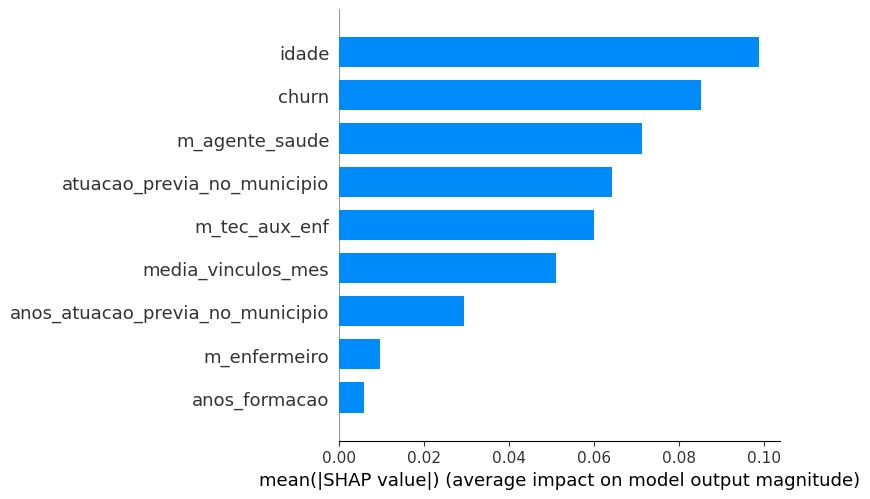

In [18]:
shap.summary_plot(shap_values, features= X_train_m2, 
                  feature_names= df_m2.columns, 
                  plot_type="bar")


### Modelo 3

In [8]:
results_m3, models_m3 = treinando_avaliando_optuna(X_train_m3, y_train_m3, X_test_m3, y_test_m3)
results_m3_df = pd.DataFrame(results_m3)
print(results_m3_df.sort_values(by='ROC AUC', ascending=False))

NameError: name 'treinando_avaliando_optuna' is not defined

In [9]:
#Escolhendo o modelo
best_model_name = results_m3_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
best_model_m3 = models_m3[best_model_name]

Melhor limiar: 0.58 com F1 Score: 1.0


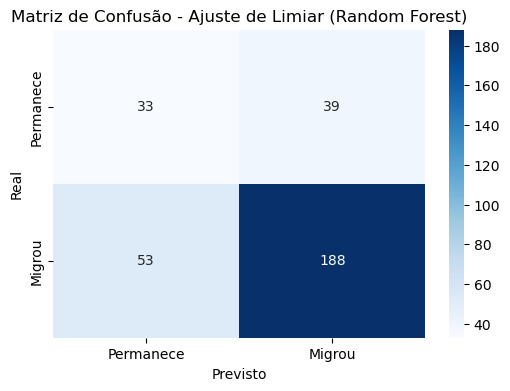

In [11]:
# Ajuste de limiar com base no conjunto de treinamento
best_model_m3.fit(X_train_m3, y_train_m3)  # Treine o modelo primeiro!

y_prob_train = best_model_m3.predict_proba(X_train_m3)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_m3, y_prob_train)

# Encontrar o melhor limiar com base no F1 Score
best_threshold = 0.5
best_f1 = 0
for threshold in thresholds:
    y_pred_adjusted = (y_prob_train >= threshold).astype(int)
    f1 = f1_score(y_train_m3, y_pred_adjusted)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Matriz de Confusão com limiar ajustado no conjunto de teste
y_prob_test = best_model_m3.predict_proba(X_test_m3)[:, 1]
y_pred_adjusted = (y_prob_test >= best_threshold).astype(int)
cm_adjusted = confusion_matrix(y_test_m3, y_pred_adjusted)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [17]:
print("ROC AUC: ", roc_auc_score(y_test_m3, y_prob_test))
print("Precision: ", precision_score(y_test_m3, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test_m3, y_pred_adjusted))
print("Recall: ", recall_score(y_test_m3, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test_m3, y_pred_adjusted))
print("Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora")

ROC AUC:  0.7596530659289995
Precision:  0.8281938325991189
Accuracy:  0.7060702875399361
Recall:  0.7800829875518672
F1 Score:  0.8034188034188035
Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora


In [13]:
# Fazendo previsões de probabilidade no conjunto de teste
y_prob_best = best_model_m3.predict_proba(X_test_m3)[:, 1]

# Ajustando as previsões com o novo limiar
y_pred_adjusted = (y_prob_best >= best_threshold).astype(int)

# Imprimindo o relatório de classificação com o limiar ajustado
print(classification_report(y_test_m3, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.38      0.46      0.42        72
           1       0.83      0.78      0.80       241

    accuracy                           0.71       313
   macro avg       0.61      0.62      0.61       313
weighted avg       0.73      0.71      0.71       313



In [19]:
explainer = shap.Explainer(best_model_m3.predict, 
                           X_test_m3)

shap_values = explainer(X_test_m3)

PermutationExplainer explainer: 314it [01:17,  3.53it/s]                         


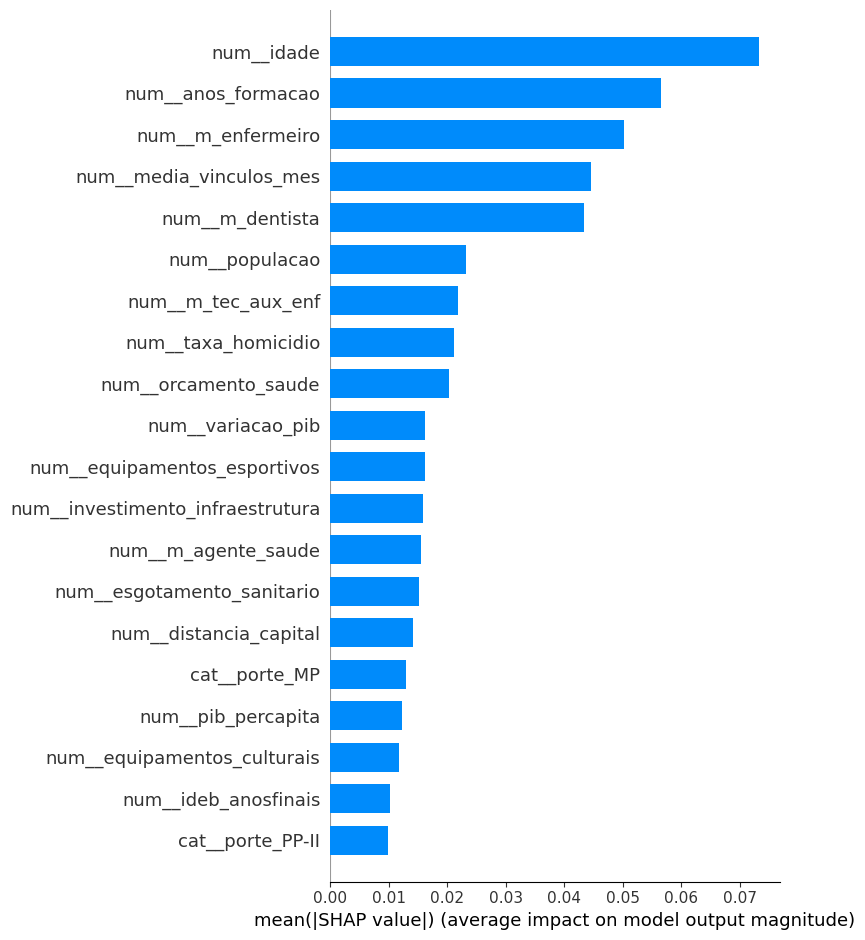

In [25]:
# Recuperando o nome das variáveis
feature_names = preprocessor_m3.get_feature_names_out()

#Gerando o gráfico
shap.summary_plot(shap_values, features= X_test_m3, 
                  feature_names= feature_names, 
                  plot_type="bar")

In [50]:
nomes_m3 = ['Idade', 'Anos de formação', 'Média de enfermeiros', 'Média de vínculos por mês', 'Média de cirurgiões-dentistas',
'População', 'Média de enfermeiros', 'Taxa de homicídio', 'Orçamento Saúde', 'Teste', 'Teste',
'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste']

shap.summary_plot(shap_values, features= X_test_m3, 
                  feature_names= nomes_m3, 
                  plot_type="bar",
                 max_display=5)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix. Perhaps the extra column in the shap_values matrix is the constant offset? Of so just pass shap_values[:,:-1].

### Modelo 4

In [31]:
results_m4, models_m4 = treinando_avaliando_optuna(X_train_m4, y_train_m4, X_test_m4, y_test_m4)
results_m4_df = pd.DataFrame(results_m4)
print(results_m4_df.sort_values(by='ROC AUC', ascending=False))

[I 2025-02-27 16:23:30,260] A new study created in memory with name: no-name-35a341fc-cd72-4fea-a0f4-00b7f9160e0b
C:\Users\alefs\AppData\Local\Temp\ipykernel_6600\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-02-27 16:23:30,279] Trial 0 finished with value: 0.8600174618885638 and parameters: {'C': 5.86520977191346}. Best is trial 0 with value: 0.8600174618885638.
C:\Users\alefs\AppData\Local\Temp\ipykernel_6600\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-02-27 16:23:30,289] Trial 1 finished with value: 0.8547151421371795 and paramet

Treinando modelo com Optuna: Logistic Regression
Melhores parâmetros para Logistic Regression: {'C': 6.395171227149846}

Treinando modelo com Optuna: Decision Tree


[I 2025-02-27 16:23:30,481] Trial 2 finished with value: 0.9314507414819265 and parameters: {'max_depth': 6}. Best is trial 1 with value: 0.9767770929413341.
[I 2025-02-27 16:23:30,500] Trial 3 finished with value: 0.8944166259654825 and parameters: {'max_depth': 4}. Best is trial 1 with value: 0.9767770929413341.
[I 2025-02-27 16:23:30,528] Trial 4 finished with value: 0.9475268087534199 and parameters: {'max_depth': 7}. Best is trial 1 with value: 0.9767770929413341.
[I 2025-02-27 16:23:30,544] Trial 5 finished with value: 0.8676505547607418 and parameters: {'max_depth': 3}. Best is trial 1 with value: 0.9767770929413341.
[I 2025-02-27 16:23:30,579] Trial 6 finished with value: 0.9845441755524915 and parameters: {'max_depth': 10}. Best is trial 6 with value: 0.9845441755524915.
[I 2025-02-27 16:23:30,594] Trial 7 finished with value: 0.8676505547607418 and parameters: {'max_depth': 3}. Best is trial 6 with value: 0.9845441755524915.
[I 2025-02-27 16:23:30,615] Trial 8 finished with v

Melhores parâmetros para Decision Tree: {'max_depth': 10}

Treinando modelo com Optuna: Random Forest


[I 2025-02-27 16:23:31,682] Trial 0 finished with value: 0.9961542783788105 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 6}. Best is trial 0 with value: 0.9961542783788105.
[I 2025-02-27 16:23:31,984] Trial 1 finished with value: 0.927999965422003 and parameters: {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 0 with value: 0.9961542783788105.
[I 2025-02-27 16:23:32,241] Trial 2 finished with value: 0.9098719101317854 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 7}. Best is trial 0 with value: 0.9961542783788105.
[I 2025-02-27 16:23:34,728] Trial 3 finished with value: 0.9963660686113909 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 6}. Best is trial 3 with value: 0.9963660686113909.
[I 2025-02-27 16:23:36,402] Trial 4 finished with value: 0.9789592887305986 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_split': 6}. Best is trial 3 with value: 0.99

Melhores parâmetros para Random Forest: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 6}

Treinando modelo com Optuna: XGBoost


C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-27 16:23:43,675] Trial 0 finished with value: 0.9811636360492909 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.028001832719328823, 'subsample': 0.7661408004196852, 'colsample_bytree': 0.9118274428833223, 'gamma': 0.11876918067080217}. Best is trial 0 with value: 0.9811636360492909.
C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:23:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-27 16:23:43,936] Trial 1 finis

Melhores parâmetros para XGBoost: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.09457562305021604, 'subsample': 0.8153289379817681, 'colsample_bytree': 0.8050856817350038, 'gamma': 0.31317176638673894}

Treinando modelo com Optuna: LightGBM
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-27 16:23:47,547] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.09403314838087203, 'num_leaves': 26, 'min_child_samples': 15}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-27 16:23:47,795] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 200, 'learning_rate': 0.0929239810539041, 'num_leaves': 36, 'min_child_samples': 15}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-27 16:23:48,163] Trial 2 finished with value: 0.9990696357640225 and parameters: {'n_estimators': 400, 'learning_rate': 0.01428752968528697, 'num_leaves': 27, 'min_child_samples': 28}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-27 16:23:48,524] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.08704990438428613, 'num_leaves': 26, 'min_child_samples': 21}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-27 16:23:48,922] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.03707990531447437, 'num_leaves': 30, 'min_child_samples': 18}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-27 16:23:49,143] Trial 5 finished with value: 0.9999556969411438 and parameters: {'n_estimators': 300, 'learning_rate': 0.0338576651881392, 'num_leaves': 21, 'min_child_samples': 27}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-27 16:23:49,361] Trial 6 finished with value: 1.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.08473382600681596, 'num_leaves': 20, 'min_child_samples': 26}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-27 16:23:49,753] Trial 7 finished with value: 1.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.0626152602111415, 'num_leaves': 24, 'min_child_samples': 28}. Best is trial 0 with value: 1.0.
[I 2025-02-27 16:23:49,913] Trial 8 finished with value: 1.0 and parameters: {'n_estimators': 200, 'learning_rate': 0.06834428971019939, 'num_leaves': 22, 'min_child_samples': 10}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-27 16:23:50,117] Trial 9 finished with value: 0.9872110035831448 and parameters: {'n_estimators': 200, 'learning_rate': 0.01107564321578662, 'num_leaves': 30, 'min_child_samples': 19}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'n_estimators': 500, 'learning_rate': 0.09403314838087203, 'num_leaves': 26, 'min_child_samples': 15}

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
2        Random Forest  0.750799   0.882629  0.780083  0.828194  0.816332
3              XGBoost  0.766773   0.847107  0.850622  0.848861  0.796277
0  Logistic Regression  0.709265   0.921348  0.680498  0.782816  0.788900
4             LightGBM  0.753994   0.841667  0.838174  0.839917  0.778239
1        Decision Tree  0.722045   0.856481  0.767635  0.

In [41]:
best_model_name = results_m4_df.sort_values(by='ROC AUC', 
                                         ascending=False).iloc[0]['Model']

best_model_m4 = models_m4[best_model_name]


Melhor limiar: 0.61 com F1 Score: 1.0


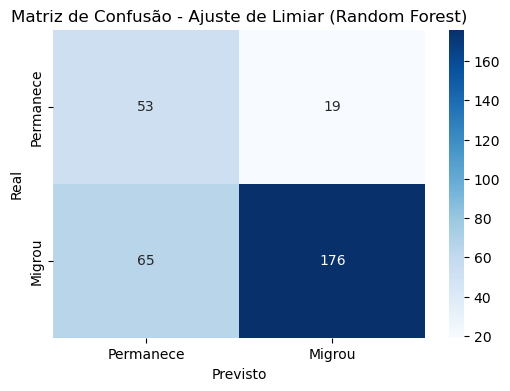

In [44]:
# Ajuste de limiar com base no conjunto de treinamento
best_model_m4.fit(X_train_m4, y_train_m4)  # Treine o modelo primeiro!

y_prob_train = best_model_m4.predict_proba(X_train_m4)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_m4, y_prob_train)

# Encontrar o melhor limiar com base no F1 Score
best_threshold = 0.5
best_f1 = 0
for threshold in thresholds:
    y_pred_adjusted = (y_prob_train >= threshold).astype(int)
    f1 = f1_score(y_train_m4, y_pred_adjusted)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Matriz de Confusão com limiar ajustado no conjunto de teste
y_prob_test = best_model_m4.predict_proba(X_test_m4)[:, 1]
y_pred_adjusted = (y_prob_test >= best_threshold).astype(int)
cm_adjusted = confusion_matrix(y_test_m3, y_pred_adjusted)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [46]:
print("ROC AUC: ", roc_auc_score(y_test_m4, y_prob_test))
print("Precision: ", precision_score(y_test_m4, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test_m4, y_pred_adjusted))
print("Recall: ", recall_score(y_test_m4, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test_m4, y_pred_adjusted))
print("Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora")

ROC AUC:  0.7998501613646842
Precision:  0.9025641025641026
Accuracy:  0.731629392971246
Recall:  0.7302904564315352
F1 Score:  0.8073394495412844
Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora


In [47]:
# Fazendo previsões de probabilidade no conjunto de teste
y_prob_best = best_model_m4.predict_proba(X_test_m4)[:, 1]

# Ajustando as previsões com o novo limiar
y_pred_adjusted = (y_prob_best >= best_threshold).astype(int)

# Imprimindo o relatório de classificação com o limiar ajustado
print(classification_report(y_test_m4, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.45      0.74      0.56        72
           1       0.90      0.73      0.81       241

    accuracy                           0.73       313
   macro avg       0.68      0.73      0.68       313
weighted avg       0.80      0.73      0.75       313



In [48]:
explainer = shap.Explainer(best_model_m4.predict, 
                           X_test_m4)

shap_values = explainer(X_test_m4)

PermutationExplainer explainer: 314it [01:13,  3.71it/s]                         


In [ ]:
# Recuperando o nome das variáveis
feature_names = preprocessor_m4.get_feature_names_out()

#Gerando o gráfico
shap.summary_plot(shap_values, features= X_test_m4, 
                  feature_names= feature_names, 
                  plot_type="bar")